In [171]:
# Utility
import math

def abs_vec(vec: list[float]) -> float:
    return math.sqrt(vec[0]**2 + vec[1]**2)

def norm_vec(vec: list[float]) -> list[float]:
    if vec == [0, 0]:
        return [0, 0]
    a: float = abs_vec(vec)
    return [vec[0] / a, vec[1] / a]

def mult_vec_scal(vec: list[float], mult: float) -> list[float]:
    return [vec[0] * mult, vec[1] * mult]

def add_vec(vec1: list[float], vec2: list[float]) -> list[float]:
    return [vec1[0] + vec2[0], vec1[1] + vec2[1]]


In [172]:
SJUNKANDE_KULA = False
ODÄMPAD_SVÄNGNING = False
DÄMPAD_SVÄNGNING = True
dts: list[float] = [0.1] # s
diameters: list[float] = [0.01] # m
y_cutoff: float = -0.1

In [173]:
p_lists_all_diameters: list[tuple[float, list[list[list[float]]]]] = []

for diameter in diameters:

    # KASTRÖRELSE

    mass: float = 0.0027 # kg
    air_density: float = 1.2 # kg/m^3
    drag_coeff: float = 0.47 # För sfär 0.47
    k: float = 1/2 * air_density * drag_coeff * (diameter/2)**2 * math.pi
    g: float = 9.82 # m/s^2

    # print(k)
    v_0_abs: float = 40
    alpha_0_deg: float = 35
    alpha_0: float = math.radians(alpha_0_deg)

    p_0: list[float] = [0,0]
    v_0: list[float] = [v_0_abs * math.cos(alpha_0), v_0_abs * math.sin(alpha_0)]

    def a_calc(v: list[float], p: list[float]) -> list[float]:
        return add_vec(mult_vec_scal(norm_vec(v), -(k/mass) * abs_vec(v)**2), [0,-g])

    # SJUNKANDE KULA
    if SJUNKANDE_KULA:
        sphere_density: float = 7870 # kg/m^3 (järn)
        fluid_density: float = 918 # kg/m^3
        V: float = 4/3 * math.pi * (diameter/2)**3
        mass: float = sphere_density * V # kg
        # viscous_drag_coeff: float = 10 # Dynamic drag
        r: float = 0.9 * (diameter/2)
        g: float = 9.82 # m/s^2

        p_0: list[float] = [0, 0]
        v_0: list[float] = [0, 0]

        def a_calc(v: list[float], p: list[float]) -> list[float]:
            return add_vec(mult_vec_scal(norm_vec(v), -r * abs_vec(v) / mass), [0, -g + fluid_density*V*g / mass])

    # SVÄNGNING
    if ODÄMPAD_SVÄNGNING or DÄMPAD_SVÄNGNING:
        mass: float = 1
        k: float = 5
        p_0: list[float] = [0, 0]
        v_0: list[float] = [0, 0]

        def a_calc(v: list[float], p: list[float]) -> list[float]:
            return [0, -g - (k*p[1] / mass)]
    
    if DÄMPAD_SVÄNGNING:
        r: float = 10

        def a_calc(v: list[float], p: list[float]) -> list[float]:
            return add_vec(mult_vec_scal(norm_vec(v), -r * abs_vec(v) / mass), [0, -g - (k*p[1] / mass)])

    # LOGIK

    t: float = 0

    p: list[float] = p_0
    v: list[float] = v_0

    p_lists: list[list[list[float]]] = []

    for dt in dts:
        p_list: list[list[float]] = []
        p = p_0
        v = v_0
        t = 0
        p_list.append(p)
        while t < 20:
            a: list[float] = a_calc(v, p)
            v = add_vec(v, mult_vec_scal(a, dt))
            p = add_vec(p, mult_vec_scal(v, dt))

            p_list.append(p)

            t += dt
        p_lists.append(p_list)

    p_lists_all_diameters.append((diameter, p_lists))

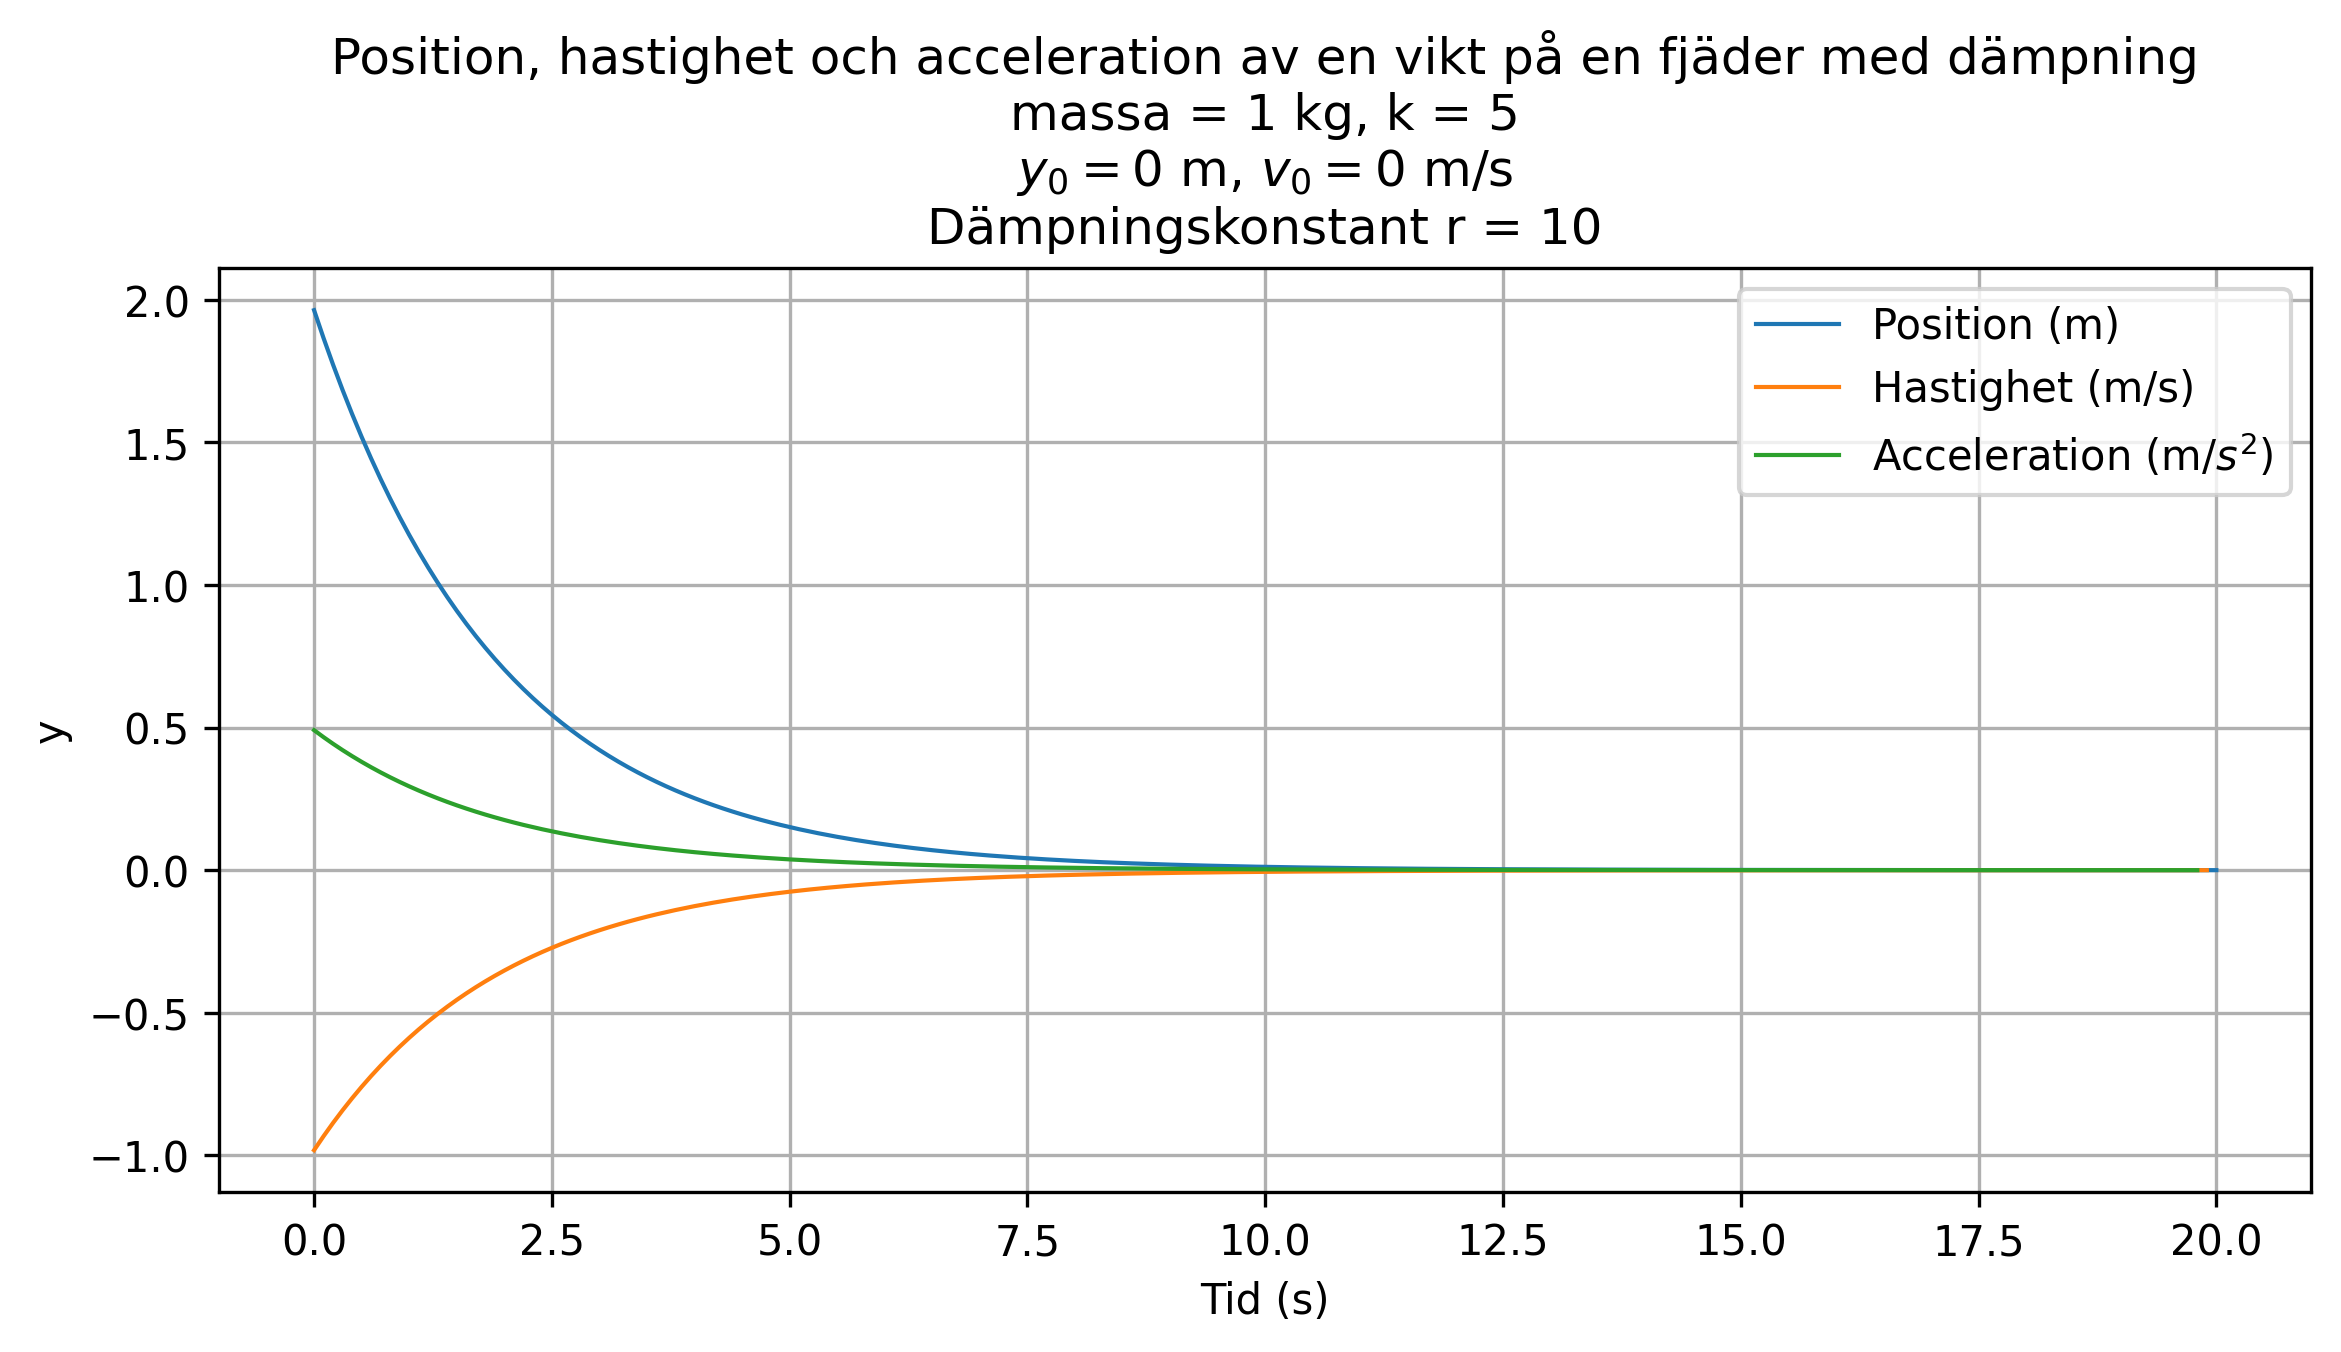

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure with two subplots
fig, axs = plt.subplots(1, 1, figsize=(9, 4), dpi=300, sharex=True)

legend_entries_position = []  # Store legend labels for position
legend_entries_velocity = []  # Store legend labels for velocity

# Iterate over each list of points and plot them
for diameter, p_lists in p_lists_all_diameters:
    for i, p_list in enumerate(p_lists):
        p_ndarray = np.array(p_list)  # Convert to NumPy array
        
        # Apply y cutoff
        # filtered_points = p_ndarray[p_ndarray[:, 1] >= y_cutoff]  # Keep only points where y >= y_cutoff
        filtered_points = p_ndarray # Skip cutoff, alter middle
        
        if filtered_points.size == 0:  # Skip empty lists after filtering
            continue
        
        x_coords, y_coords = filtered_points[:, 0], filtered_points[:, 1]  # Extract x and y
        times = np.arange(len(y_coords)) * dts[i]  # Compute time values

        # Compute y velocity (finite difference method)
        v_y = np.diff(y_coords) / dts[i]  # First derivative of y
        a_y = np.diff(v_y) / dts[i]  # First derivative of v
        v_times = times[:-1]  # Time points for velocity
        a_times = v_times[:-1]  # Time points for acceleration

        # Plot y position
        axs.plot(times, y_coords + mass*g/k, linestyle='-', linewidth=1, label=f"Position (m)")
        
        # Plot y velocity
        axs.plot(v_times, v_y, linestyle='-', linewidth=1, label=f"Hastighet (m/s)")
        
        # Plot y velocity
        axs.plot(a_times, a_y, linestyle='-', linewidth=1, label=f"Acceleration (m/$s^2$)")


        # Find x-axis crossings (where y changes sign) and y-max
        crossing_index = 0
        x_cross = 0
        y_max_index = np.argmax(y_coords)  # Index of max y

        for j in range(len(y_coords) - 1):
            # Detect y = 0 crossing
            if y_coords[j] * y_coords[j + 1] < 0:  
                x_cross = x_coords[j] - (y_coords[j] * (x_coords[j + 1] - x_coords[j]) / (y_coords[j + 1] - y_coords[j]))
                crossing_index = j  # Store crossing index
        

# Labels and titles
axs.set_xlabel("Tid (s)")
axs.set_ylabel("y")
axs.set_title(f"Position, hastighet och acceleration av en vikt på en fjäder med dämpning\nmassa = {mass} kg, k = {k}\n$y_0 = {p_0[1]}$ m, $v_0 = {v_0[1]}$ m/s\nDämpningskonstant r = {r}")
axs.legend(loc="best")
axs.grid(True)

# Show the plot
plt.show()
